In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek  # Menggunakan SMOTE-Tomek (Hybrid)
from sklearn.preprocessing import RobustScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("dataset.csv")
df.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
df['Gender_Encoded'] = df['Gender'].map({'Female': 0, 'Male': 1})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             566 non-null    int64  
 1   Gender          566 non-null    object 
 2   TB              566 non-null    float64
 3   DB              566 non-null    float64
 4   Alkphos         566 non-null    int64  
 5   Sgpt            566 non-null    int64  
 6   Sgot            566 non-null    int64  
 7   TP              566 non-null    float64
 8   ALB             566 non-null    float64
 9   A/G Ratio       566 non-null    float64
 10  Selector        566 non-null    int64  
 11  Gender_Encoded  566 non-null    int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 53.2+ KB


In [5]:
df = df.drop(columns=['Gender'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             566 non-null    int64  
 1   TB              566 non-null    float64
 2   DB              566 non-null    float64
 3   Alkphos         566 non-null    int64  
 4   Sgpt            566 non-null    int64  
 5   Sgot            566 non-null    int64  
 6   TP              566 non-null    float64
 7   ALB             566 non-null    float64
 8   A/G Ratio       566 non-null    float64
 9   Selector        566 non-null    int64  
 10  Gender_Encoded  566 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 48.8 KB


In [7]:
def cap_outliers_iqr(df, columns):
    df_clean = df.copy()
    print("--- Memulai IQR Capping ---")
    
    for col in columns:
        # Hitung statistik dasar
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_limit = Q1 - (1.5 * IQR)
        upper_limit = Q3 + (1.5 * IQR)
        
        # Cek nilai max sebelum dipangkas (untuk perbandingan)
        max_before = df_clean[col].max()
        
        # Lakukan Capping (Clip)
        df_clean[col] = df_clean[col].clip(lower=lower_limit, upper=upper_limit)
        
        # Cek nilai max setelah dipangkas
        max_after = df_clean[col].max()
        
        # Print info jika ada perubahan
        if max_before > max_after:
            print(f"Kolom '{col}': Nilai max dipangkas dari {max_before} -> {max_after} (Batas Atas)")
            
    print("--- Selesai ---\n")
    return df_clean

# ==========================================
# CARA PENGGUNAAN
# ==========================================

# 1. Tentukan kolom yang banyak outlier (biasanya Enzim & Bilirubin)
cols_to_cap = ['Sgpt', 'Sgot', 'Alkphos', 'TB', 'DB']

# 2. Terapkan fungsi ke dataframe Anda (misal namanya 'df')
# Pastikan 'df' sudah ada sebelumnya
df_capped = cap_outliers_iqr(df, cols_to_cap)

# 3. Cek Statistik Setelah Capping
print("Statistik Data Setelah IQR Capping:")
print(df_capped[cols_to_cap].describe())

--- Memulai IQR Capping ---
Kolom 'Sgpt': Nilai max dipangkas dari 2000 -> 117.375 (Batas Atas)
Kolom 'Sgot': Nilai max dipangkas dari 4929 -> 180 (Batas Atas)
Kolom 'Alkphos': Nilai max dipangkas dari 2110 -> 481 (Batas Atas)
Kolom 'TB': Nilai max dipangkas dari 75.0 -> 5.300000000000001 (Batas Atas)
Kolom 'DB': Nilai max dipangkas dari 19.7 -> 2.95 (Batas Atas)
--- Selesai ---

Statistik Data Setelah IQR Capping:
             Sgpt        Sgot     Alkphos          TB          DB
count  566.000000  566.000000  566.000000  566.000000  566.000000
mean    47.958701   64.549470  251.977032    1.926502    0.883922
std     33.506604   53.715015  110.031457    1.656653    0.998179
min     10.000000   10.000000   63.000000    0.400000    0.100000
25%     23.000000   25.000000  176.000000    0.800000    0.200000
50%     35.000000   41.000000  208.000000    1.000000    0.300000
75%     60.750000   87.000000  298.000000    2.600000    1.300000
max    117.375000  180.000000  481.000000    5.300000

/var/folders/sh/rr1hnjjn0t38l50lsbqf8bl80000gn/T/ipykernel_50636/1101559298.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Selector', y=col, data=df_capped, palette='Set2')
/var/folders/sh/rr1hnjjn0t38l50lsbqf8bl80000gn/T/ipykernel_50636/1101559298.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Selector', y=col, data=df_capped, palette='Set2')
/var/folders/sh/rr1hnjjn0t38l50lsbqf8bl80000gn/T/ipykernel_50636/1101559298.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Selector', y=col, data=df_capped, palette='Set2')
/var

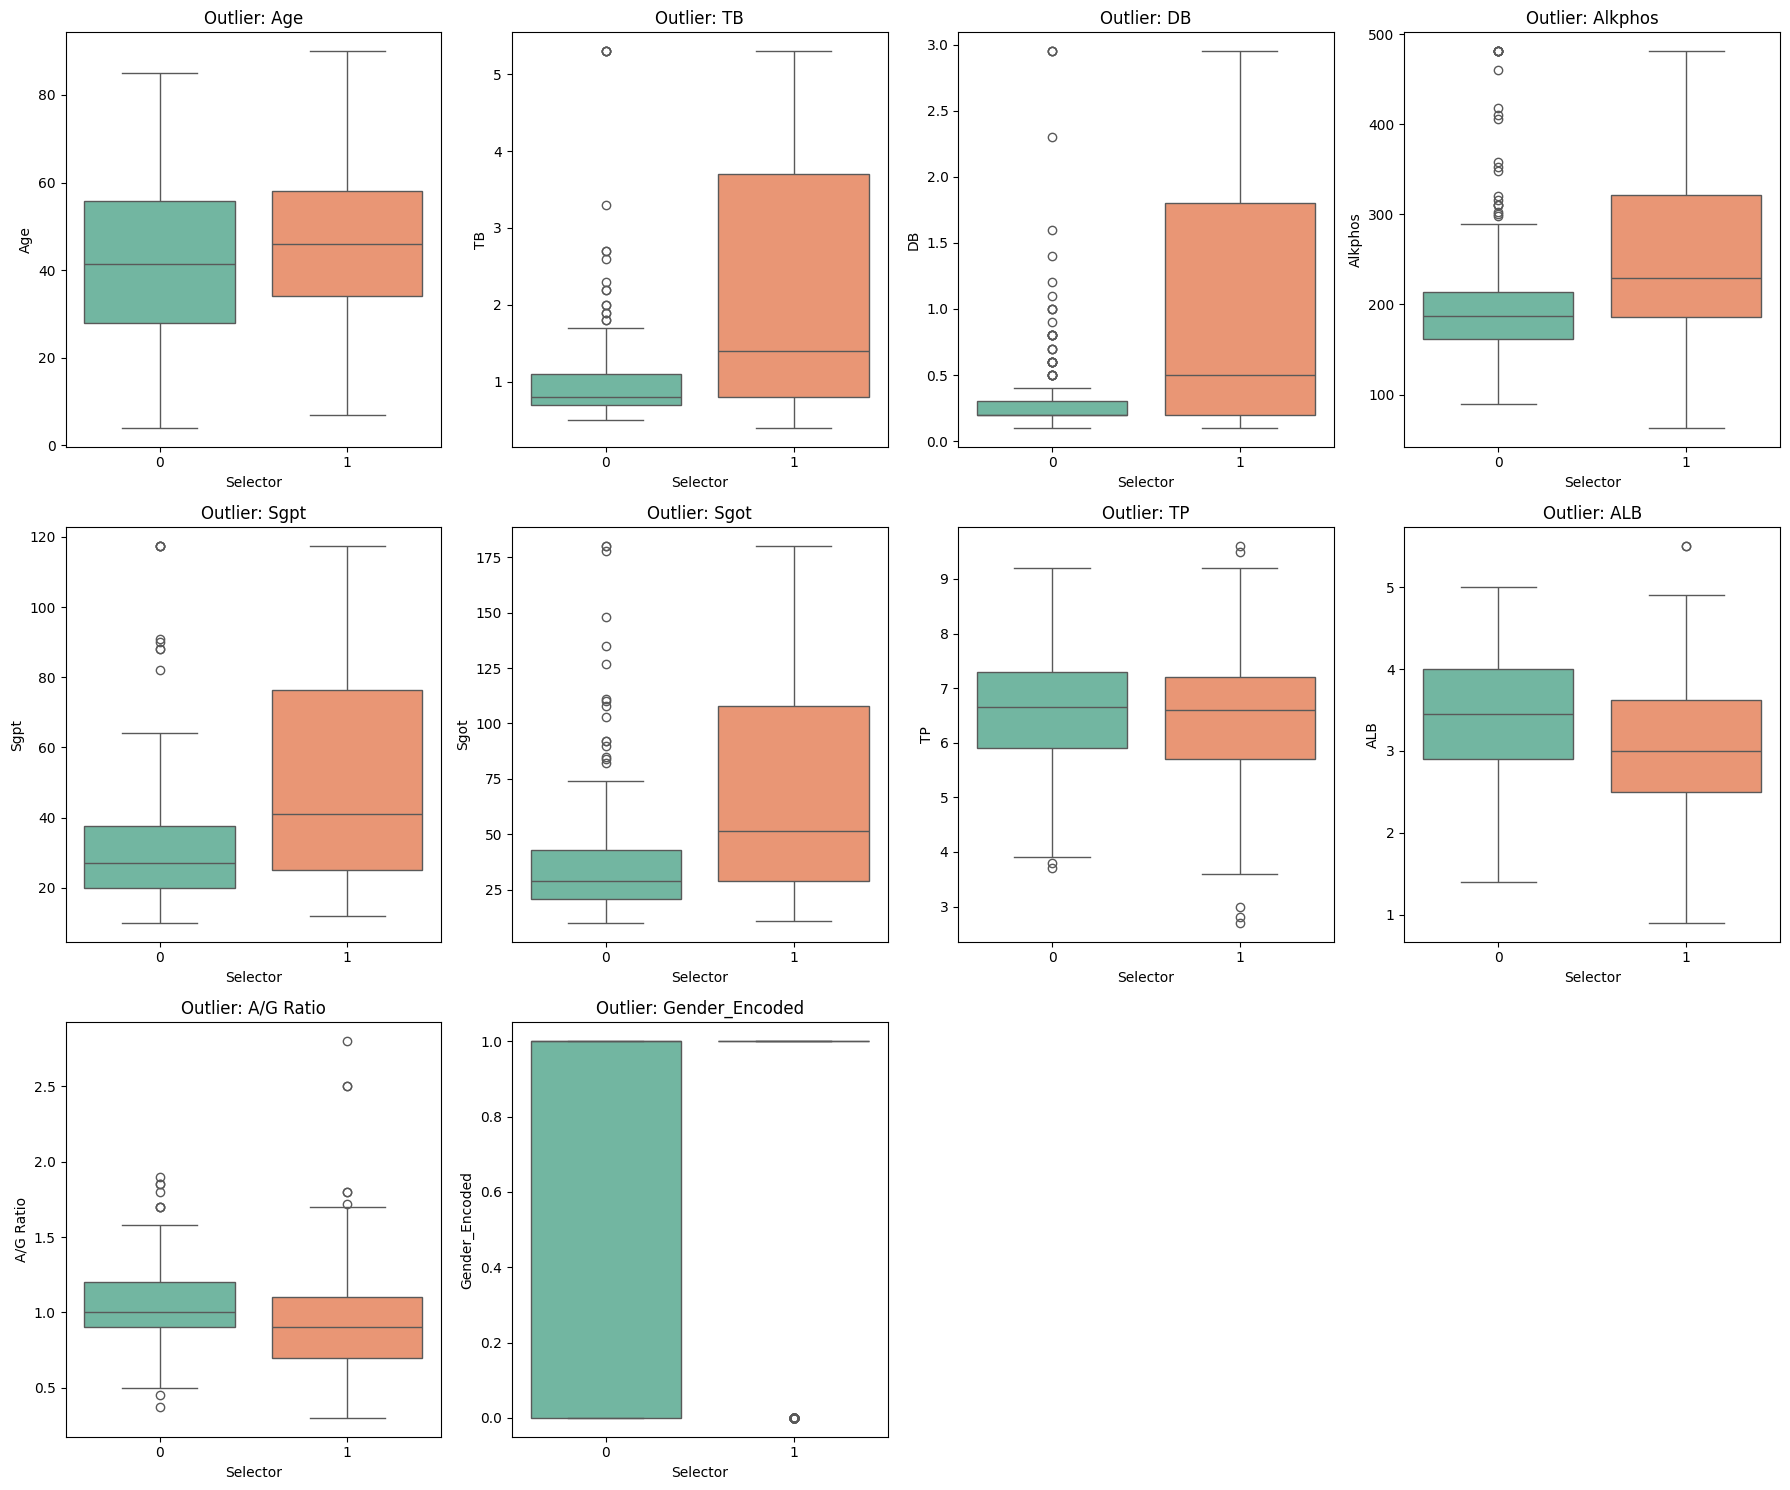

In [8]:
plt.figure(figsize=(18, 15))
num_cols = df_capped.select_dtypes(include=['float64', 'int64']).columns.drop('Selector')

for i, col in enumerate(num_cols):
    plt.subplot(3, 4, i + 1)
    
    # Boxplot membandingkan Sehat (0) vs Sakit (1)
    sns.boxplot(x='Selector', y=col, data=df_capped, palette='Set2')
    
    plt.title(f'Outlier: {col}')

plt.tight_layout()
plt.show()

In [9]:
X = df_capped.drop(columns=['Selector'])
y = df_capped["Selector"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
import pandas as pd

# 1. Tentukan kolom mana yang mau di-scale (Semua KECUALI 'Gender')
# Kita ambil nama semua kolom, lalu buang 'Gender' dari list
cols_to_scale = [col for col in X_train.columns if col != 'Gender']

# 2. Siapkan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num',          RobustScaler(),    cols_to_scale)
    ],
    remainder='passthrough',  # PENTING: Kolom sisa ('Gender') dibiarkan lewat tanpa diubah
    verbose_feature_names_out=False # Agar nama kolom tidak berubah jadi aneh (misal: num__Age)
).set_output(transform="pandas") # FITUR BARU: Output langsung jadi DataFrame (bukan array)

# 3. Terapkan pada Data
# fit_transform pada Train
X_train_scaled = preprocessor.fit_transform(X_train)

# transform saja pada Test
X_test_scaled = preprocessor.transform(X_test)

# Cek hasil
print("Preview Data (Gender tidak berubah, yang lain berubah):")
print(X_train_scaled.head())

Preview Data (Gender tidak berubah, yang lain berubah):
          Age      TB    DB   Alkphos      Sgpt      Sgot        TP       ALB  \
107  0.192308  2.6875  2.65  2.237705  2.327586  2.384615 -0.641509 -0.727273   
381 -0.269231 -0.1250 -0.10  0.000000 -0.220690  0.162393  0.415094  0.545455   
182  0.153846  0.6250  0.30  0.008197  0.413793 -0.145299 -0.641509 -0.090909   
296 -0.576923 -0.1250 -0.10 -0.409836 -0.220690 -0.316239  1.018868  1.272727   
277 -0.846154  0.0625  0.20 -0.139344  0.110345  0.008547  0.867925  1.090909   

     A/G Ratio  Gender_Encoded  
107     -0.675             0.0  
381      0.150             0.0  
182      0.400             0.0  
296      0.900            -1.0  
277      0.650             0.0  


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report

# 1. Inisialisasi Model
rf_model = RandomForestClassifier(
    n_estimators=100,       # Jumlah pohon (default 100)
    random_state=42,        # Agar hasil konsisten
    class_weight='balanced' # PENTING: Mengatasi data imbalanced (Sakit vs Sehat)
)

# 2. Latih Model (Fit)
rf_model.fit(X_train_scaled, y_train)

# 1. Lakukan Prediksi (Jika belum)
y_pred = rf_model.predict(X_test_scaled)

# 2. Tampilkan Report
# target_names membantu kita membaca label (0 itu apa, 1 itu apa)
print(classification_report(y_test, y_pred, target_names=['Sehat (0)', 'Sakit (1)']))

              precision    recall  f1-score   support

   Sehat (0)       0.62      0.24      0.35        33
   Sakit (1)       0.75      0.94      0.84        81

    accuracy                           0.74       114
   macro avg       0.68      0.59      0.59       114
weighted avg       0.71      0.74      0.69       114



--- Evaluasi XGBoost ---
Akurasi: 0.70 (70.2%)

Classification Report:
              precision    recall  f1-score   support

   Sehat (0)       0.47      0.27      0.35        33
   Sakit (1)       0.75      0.88      0.81        81

    accuracy                           0.70       114
   macro avg       0.61      0.57      0.58       114
weighted avg       0.67      0.70      0.67       114



/opt/homebrew/Caskroom/miniconda/base/envs/jokisatrio/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [16:54:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


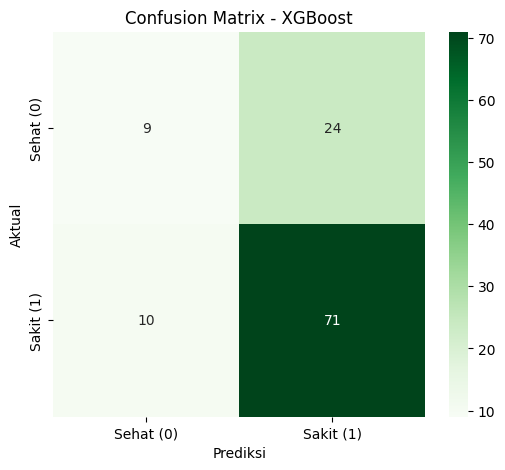

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Inisialisasi Model XGBoost
# use_label_encoder=False untuk menghindari warning di versi baru
# eval_metric='logloss' agar tidak muncul warning default metric
xgb_model = XGBClassifier(
    n_estimators=100,       # Jumlah putaran boosting
    learning_rate=0.1,      # Seberapa cepat model belajar (0.01 - 0.3)
    max_depth=5,            # Kedalaman pohon (makin dalam makin rawan overfitting)
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42)

# 2. Latih Model
xgb_model.fit(X_train_scaled, y_train)

# 3. Prediksi
y_pred_xgb = xgb_model.predict(X_test_scaled)

# ---------------- EVALUASI ----------------
print("--- Evaluasi XGBoost ---")
acc = accuracy_score(y_test, y_pred_xgb)
print(f"Akurasi: {acc:.2f} ({acc*100:.1f}%)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Sehat (0)', 'Sakit (1)']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Sehat (0)', 'Sakit (1)'],
            yticklabels=['Sehat (0)', 'Sakit (1)'])
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()